In [4]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle

# display options
pd.set_option('display.max_columns', 200)
%matplotlib inline


In [5]:

csv_file = "Customer-Churn.csv"
df = pd.read_csv(csv_file)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Cell 3
df.shape, df.columns.tolist(), df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Cell 4
# TotalCharges sometimes is string blanks — convert safely
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Drop ID
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
# Cell 5
print("Overall churn rate:")
print(df['Churn'].value_counts(normalize=True)*100)

# Churn by Contract
churn_contract = pd.crosstab(df['Contract'], df['Churn'], normalize='index')*100
churn_contract


Overall churn rate:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


Churn,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.730482,11.269518
Two year,97.168142,2.831858


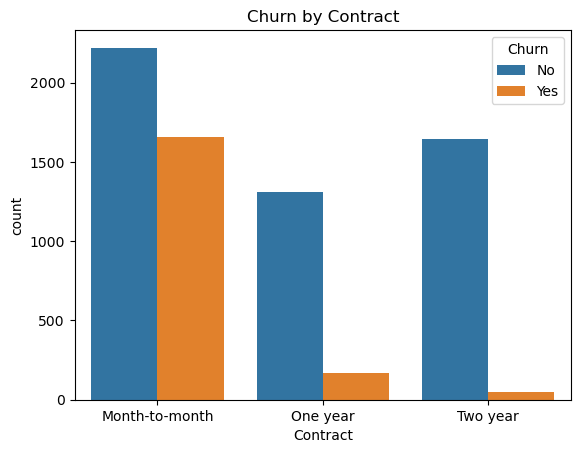

In [10]:
# optional visualization
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn by Contract")
plt.show()


In [11]:
# Cell 6
# Map simple yes/no columns to 1/0
binary_cols = ['Partner','Dependents','PhoneService','PaperlessBilling']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes':1,'No':0})

# Map target churn
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

# Some columns have 'No internet service' replace with 'No' for simplicity
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in replace_cols:
    if col in df.columns:
        df[col] = df[col].replace({'No internet service':'No'})

# One-hot encode remaining categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols


['gender',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [12]:
# Continue encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.shape


(7043, 25)

In [13]:
# Cell 7
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features (optional but recommended)
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [14]:
# Cell 8
conn = sqlite3.connect("churn_project.db")   # creates a file in current folder
# Save original CSV into SQL table (use original df before get_dummies or use read again)
orig = pd.read_csv(csv_file)
orig.to_sql("customer_churn_raw", conn, if_exists="replace", index=False)
# quick SQL query example from Python
q = "SELECT Contract, COUNT(*) as total, SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) as churn_count FROM customer_churn_raw GROUP BY Contract"
pd.read_sql_query(q, conn)


,Contract,total,churn_count
0,Month-to-month,3875,1655
1,One year,1473,166
2,Two year,1695,48


In [15]:
# Cell 9
# Logistic Regression
log = LogisticRegression(max_iter=2000, solver='liblinear')
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Logistic Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Logistic Accuracy: 0.8034066713981547
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

Random Forest Accuracy: 0.7913413768630234
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



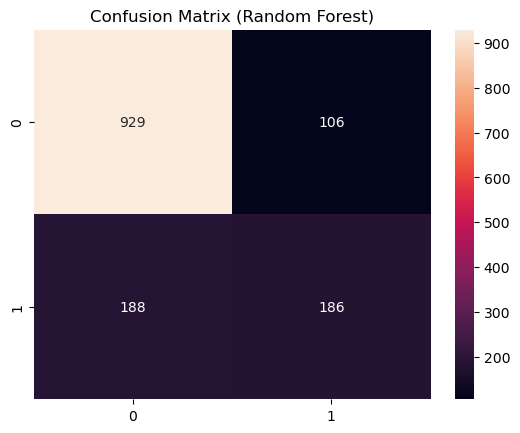

Random Forest ROC AUC: 0.826396961946834


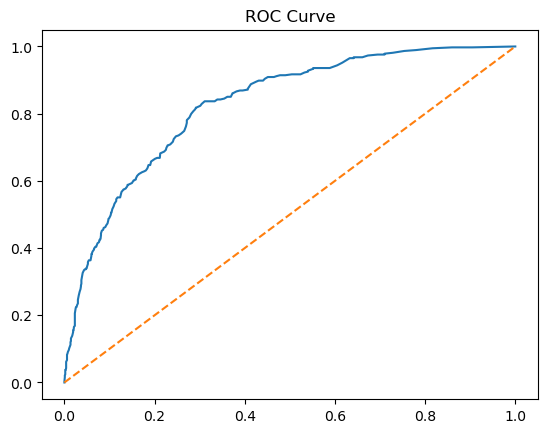

In [16]:
# Cell 10
# Confusion matrix (RF)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Random Forest)")
plt.show()

# ROC AUC
y_proba = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("Random Forest ROC AUC:", auc)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.show()


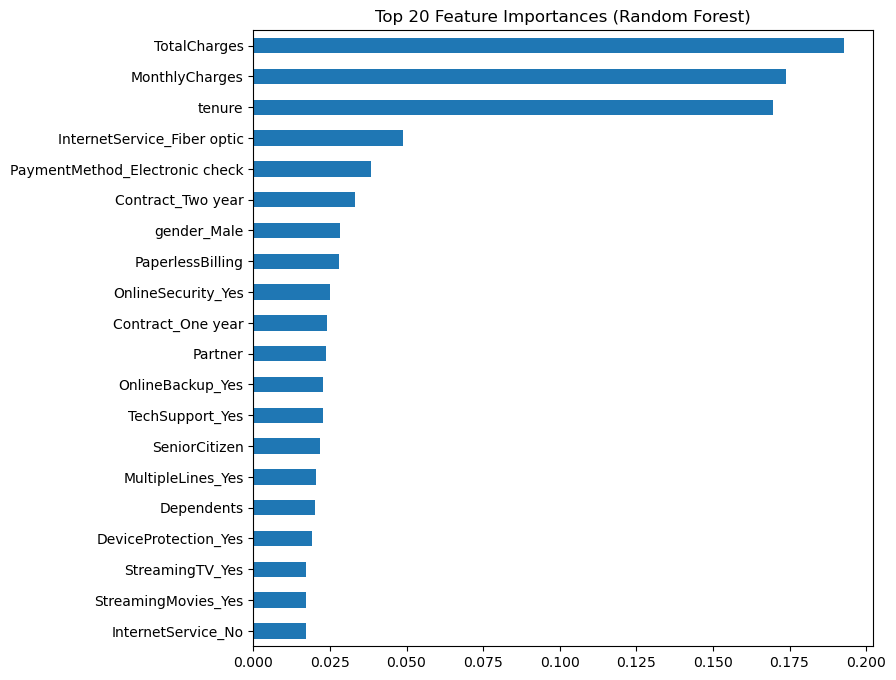

In [17]:
# Cell 11
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
feat_imp.plot(kind='barh', figsize=(8,8))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


In [18]:
# Cell 12
with open('rf_churn_model.pkl','wb') as f:
    pickle.dump(rf, f)

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)
